In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

from spectrum import FitsSpectrum
from common import list_files, list_directories, tqdm

### General functions

In [5]:
dib_centers_all = np.loadtxt('data/dibs_list.csv')
dib_centers_subset = [5780,5797,6196,6379,6613,7224]

def load_target(target_dir: str) -> list[FitsSpectrum]:
    return [FitsSpectrum(datafile) for band_dir in list_directories(target_dir) for datafile in list_files(band_dir)]

def fit_gaussian_for_subspectrum(
    subspectrum: FitsSpectrum,
    create_figure = False,
    export_data: list | None = None,
    table_data: list | None = None,
    dib_slice: tuple[int, int] | None = None,
    expected_dib_centers: np.typing.NDArray | None = None,
    tqdm_position: int = 0,
    show_error = False
):
    wvl_max, wvl_min = np.max(subspectrum.wavelength), np.min(subspectrum.wavelength)

    subspectrum.remove_outliers()
    subspectrum.correct_shift()

    dibs = list(subspectrum.select_dibs().items())
    dibs_tqdm = tqdm(dibs if dib_slice is None else dibs[dib_slice[0]:dib_slice[1]], position=tqdm_position)
    for center, bounds in dibs_tqdm:
        dibs_tqdm.set_description(f'λ={wvl_min:.2f}-{wvl_max:.2f} [{center:.2f}]')

        # The DIB does not lie in this subspectrum or is not an expected DIB (within 1 angstrom)
        if not wvl_min < center < wvl_max or (expected_dib_centers is not None and np.all(np.abs(expected_dib_centers - center) > 1)):
            continue

        fig, ax = None, None
        if create_figure:
            fig, ax = plt.subplots(1, 1, figsize=(15, 12))

        result = subspectrum.fit_gaussian(center, bounds, ax=ax, show_error=show_error, max_gaussians=3)

        if result is None:
            continue

        fig.savefig(f'export/{subspectrum.target}_{np.round(center).astype(int)}_gauss.pdf')

        params, rmse, r2, fwhm, ew = result
        centers, widths, amplitudes, skews = np.column_stack(params)

        if table_data is not None:
            table_data.append([subspectrum.target, subspectrum.format_obs_date(), bounds[0], bounds[1], *np.column_stack(params), rmse, r2, fwhm, ew])

        if export_data is not None:
            export_data.append('\t'.join([
                subspectrum.obs_date.isoformat(),
                str(bounds[0]), str(bounds[1]),
                np.array2string(centers, separator=','),
                np.array2string(amplitudes, separator=','),
                np.array2string(widths, separator=','),
                np.array2string(skews, separator=','),
                str(rmse), str(r2), str(fwhm), str(ew)
            ]).replace('\n', ' ').replace('\r', ' ').strip())


def fit_gaussian_for_targets(
    targets: list | str,
    expected_dib_centers: np.typing.NDArray | None = None,
    export = False,
    create_figure = False,
    show_error = False
):
    headers = ['Observation date', 'Start [Å]', 'End [Å]', 'Center [Å]', 'Width', 'Amplitude', 'Skew', 'RMSE', 'R2', 'FWHM [Å]', 'EW [Å]']
    table_data = []

    if type(targets) == str:
        targets = [targets]

    targets_tqdm = tqdm(targets)
    for target in targets_tqdm:
        export_data = ['# ' + '\t'.join(headers)] if export else None
        subspectra = load_target(f'data/fits/{target}')
        
        for subspectrum in subspectra:
            targets_tqdm.set_description(f'{subspectrum.target} | {subspectrum.format_obs_date()}')
            fit_gaussian_for_subspectrum(subspectrum, create_figure, export_data, table_data, expected_dib_centers=expected_dib_centers, tqdm_position=1, show_error=show_error)

        if export:
            export_file = open(f'export/{target}_gaussians.csv', 'w+')
            export_file.write('\n'.join(export_data))
            export_file.close()

    return tabulate(table_data, ['Target', *headers], tablefmt='html')


### Subset of HD170740

λ=5654.46-6686.46 [6654.80]: 100%|██████████| 219/219 [00:01<00:00, 218.46it/s]


Target,Observation date,Start [Å],End [Å],Center [Å],Width,Amplitude,Skew,RMSE,R2,FWHM [Å],EW [Å]
HD170740,"12-06-2016, 06:12:33",5777.93,5783.01,[5780.46774183],[0.54763044],[0.86271269],[0.15267146],0.0383985,0.98583,1.28957,1.82278
HD170740,"12-06-2016, 06:12:33",5795.91,5797.63,[5796.75296087 5797.05297491],[0.07187955 0.1148423 ],[0.6922046 0.72198299],[0.02357143 0.15144491],0.0480025,0.981845,0.270433,0.540173
HD170740,"12-06-2016, 06:12:33",6612.32,6614.64,[6613.45705925 6613.75707546 6613.13704197],[0.22987637 0.07253033 0.04885678],[0.83816905 0.02713418 0.29468164],[-0.10294094 -2. 0.10956475],0.041776,0.983941,0.541317,0.793206


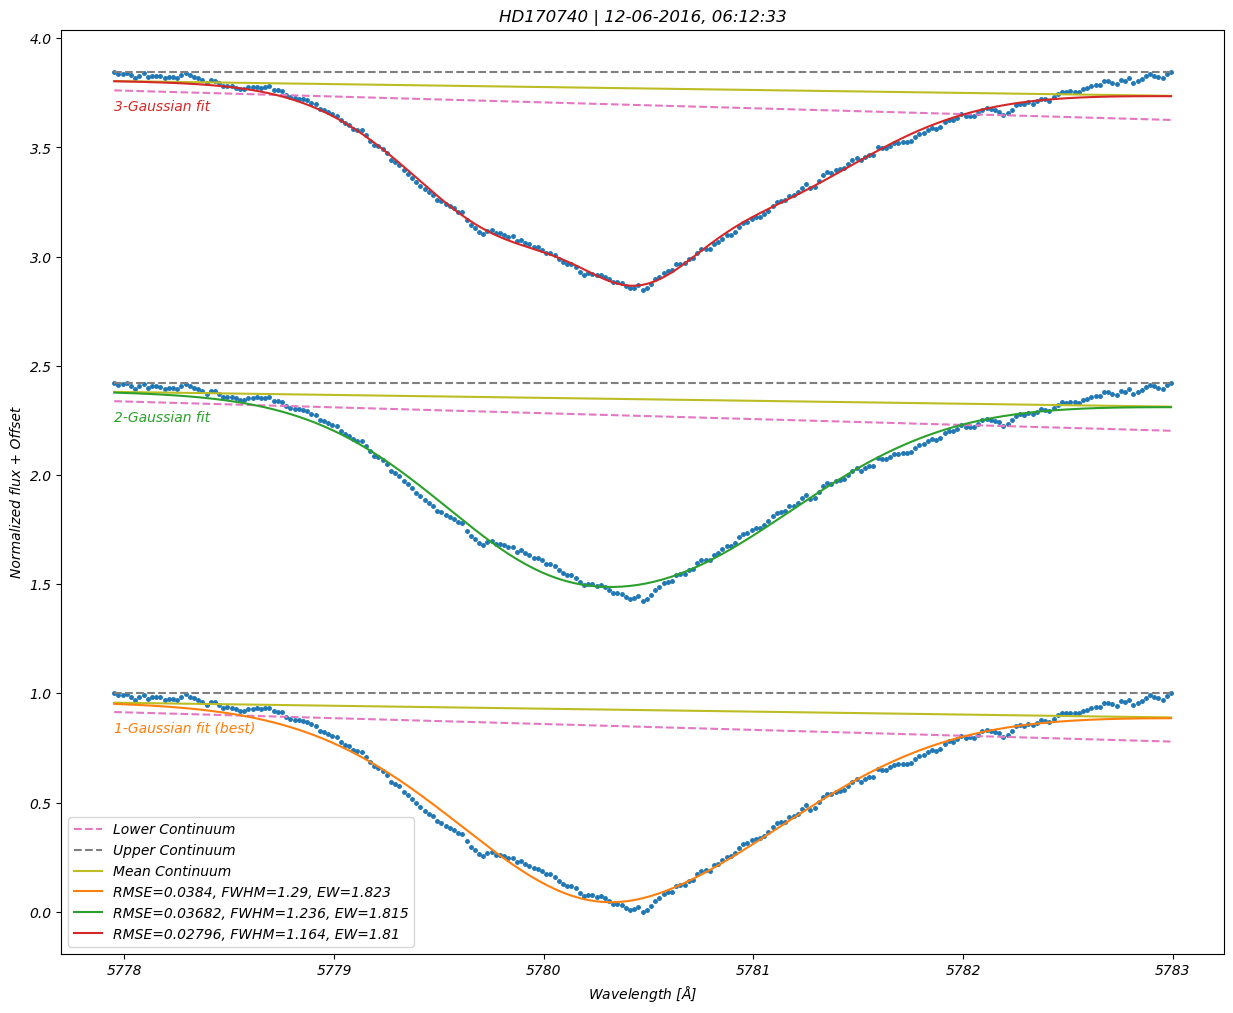

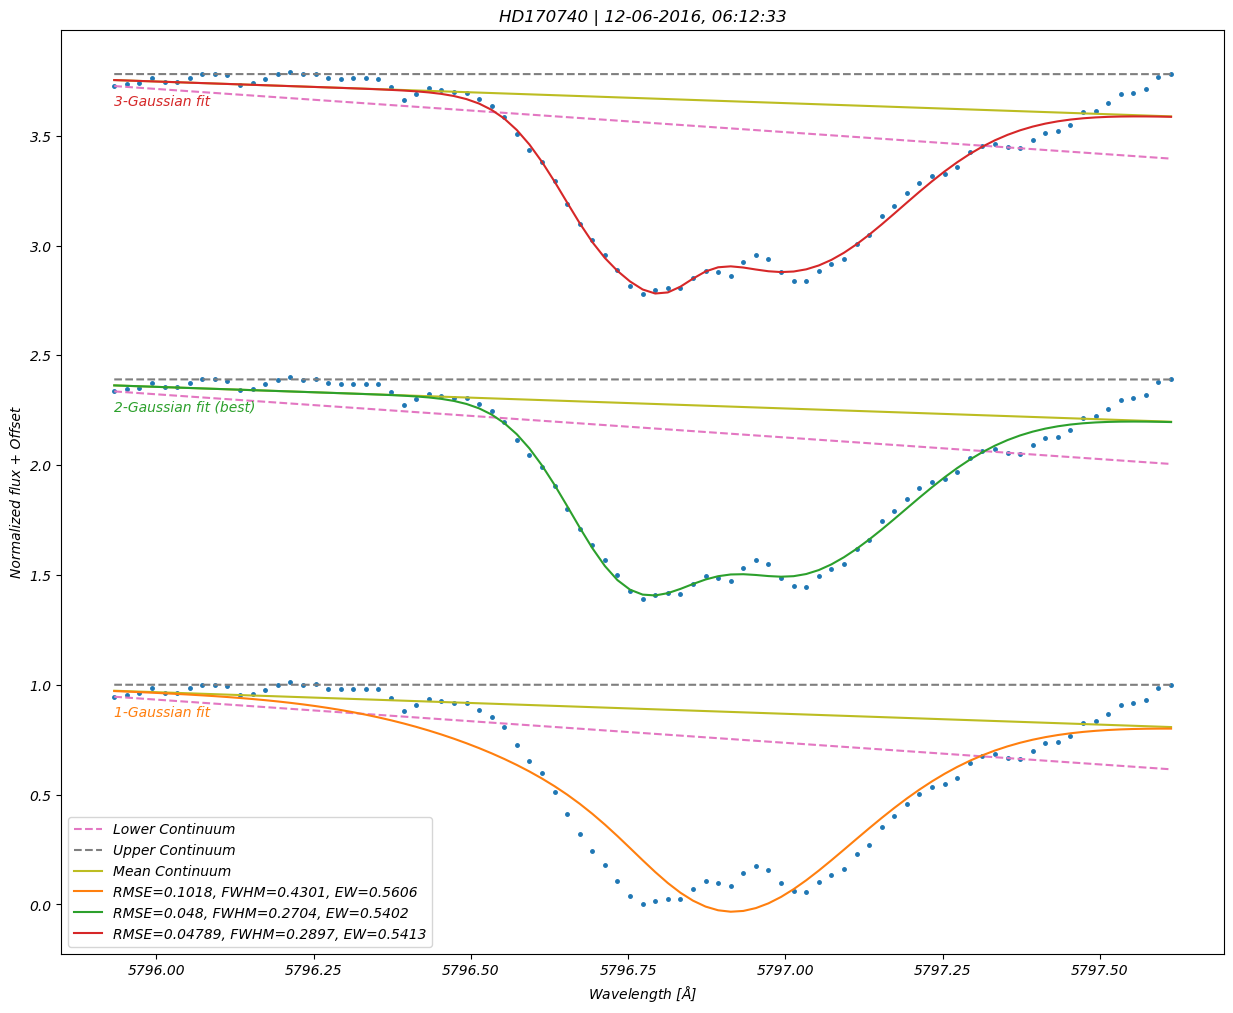

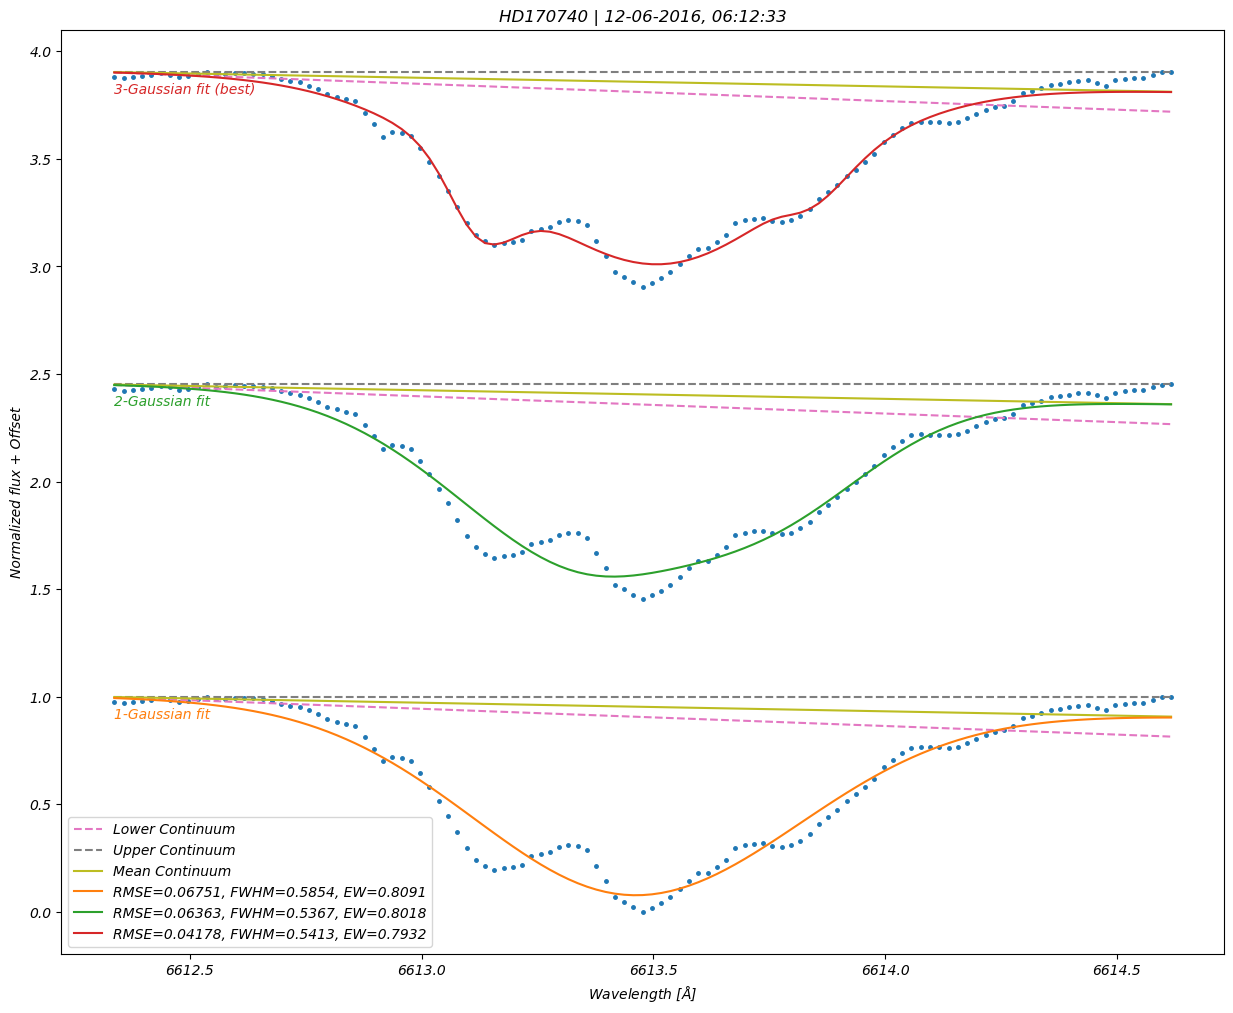

In [6]:
headers = ['Observation date', 'Start [Å]', 'End [Å]', 'Center [Å]', 'Width', 'Amplitude', 'Skew', 'RMSE', 'R2', 'FWHM [Å]', 'EW [Å]']
table_data = []

fit_gaussian_for_subspectrum(
    FitsSpectrum('data/fits/HD170740/RED_564/HD170740_w564_n9_20160612_U.fits'),
    expected_dib_centers=[5780, 5797, 6613],
    create_figure=True,
    table_data=table_data
    # save_plot='5780_gauss.pdf'
    # show_error=True
)

tabulate(table_data, ['Target', *headers], tablefmt='html')

### Subset of HD185859

λ=5654.48-6686.50 [6654.49]: 100%|██████████| 287/287 [00:01<00:00, 263.82it/s]


Target,Observation date,Start [Å],End [Å],Center [Å],Width,Amplitude,Skew,RMSE,R2,FWHM [Å],EW [Å]
HD185859,"13-08-2016, 03:07:33",5777.75,5782.67,[5780.19367364],[0.55038703],[0.90602022],[0.1447898],0.036364,0.98824,1.29606,1.91149
HD185859,"13-08-2016, 03:07:33",5795.79,5797.35,[5796.59286361 5796.77285272],[0.09615846 0.11245599],[0.71286479 0.54033086],[ 0.27152932 -0.39419355],0.0362539,0.989672,0.264814,0.527709
HD185859,"13-08-2016, 03:07:33",6612.05,6614.33,[6613.20999694 6612.93244361 6613.29242975],[0.07331023 0.09687736 0.18975103],[0.5189287 0.71256416 0.53164657],[ 0.03944675 0.23808266 -0.66375039],0.0173711,0.99773,0.44683,0.823547


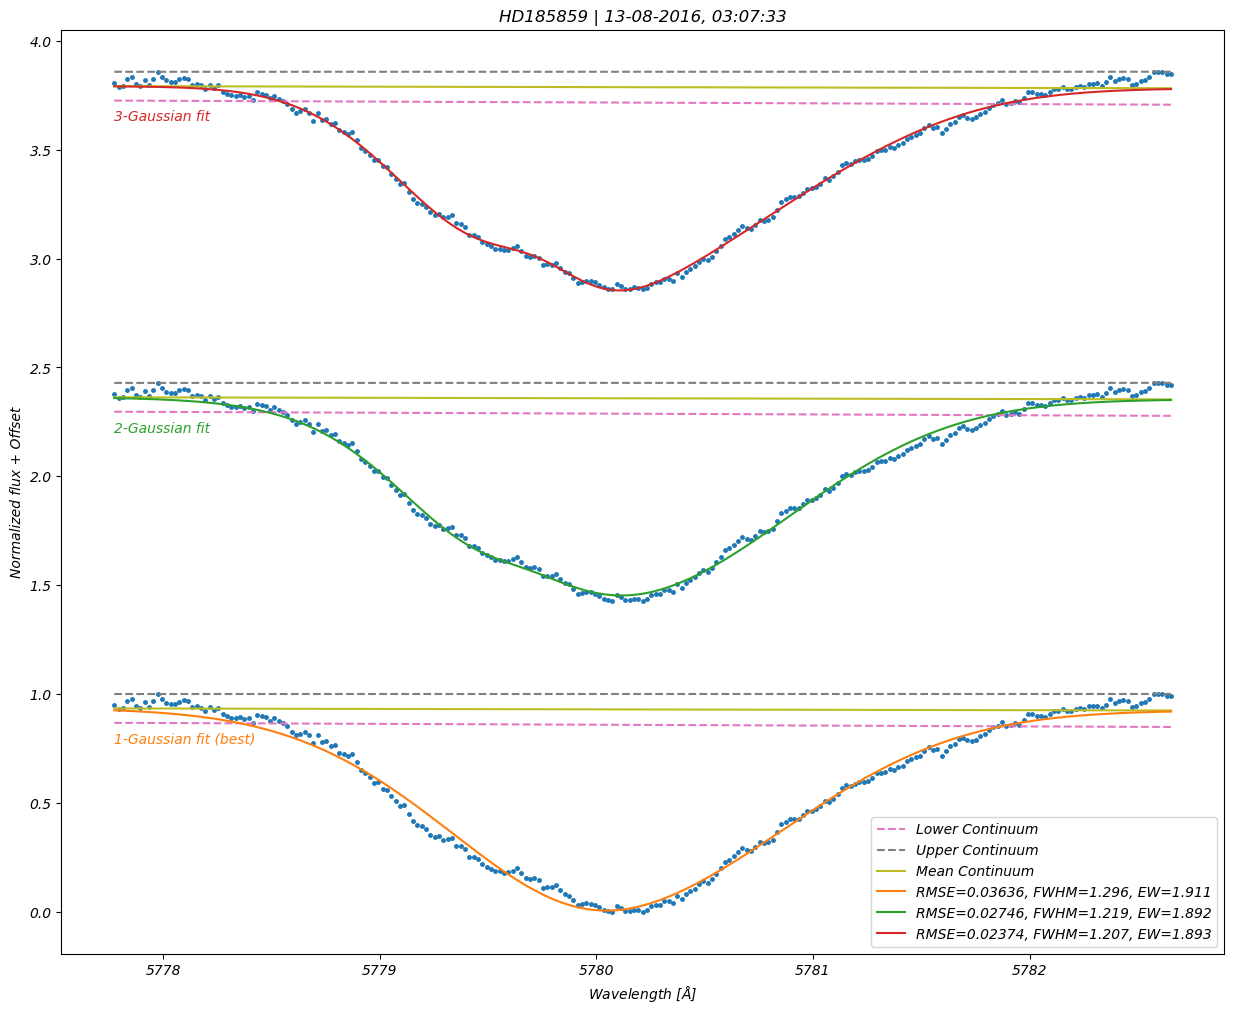

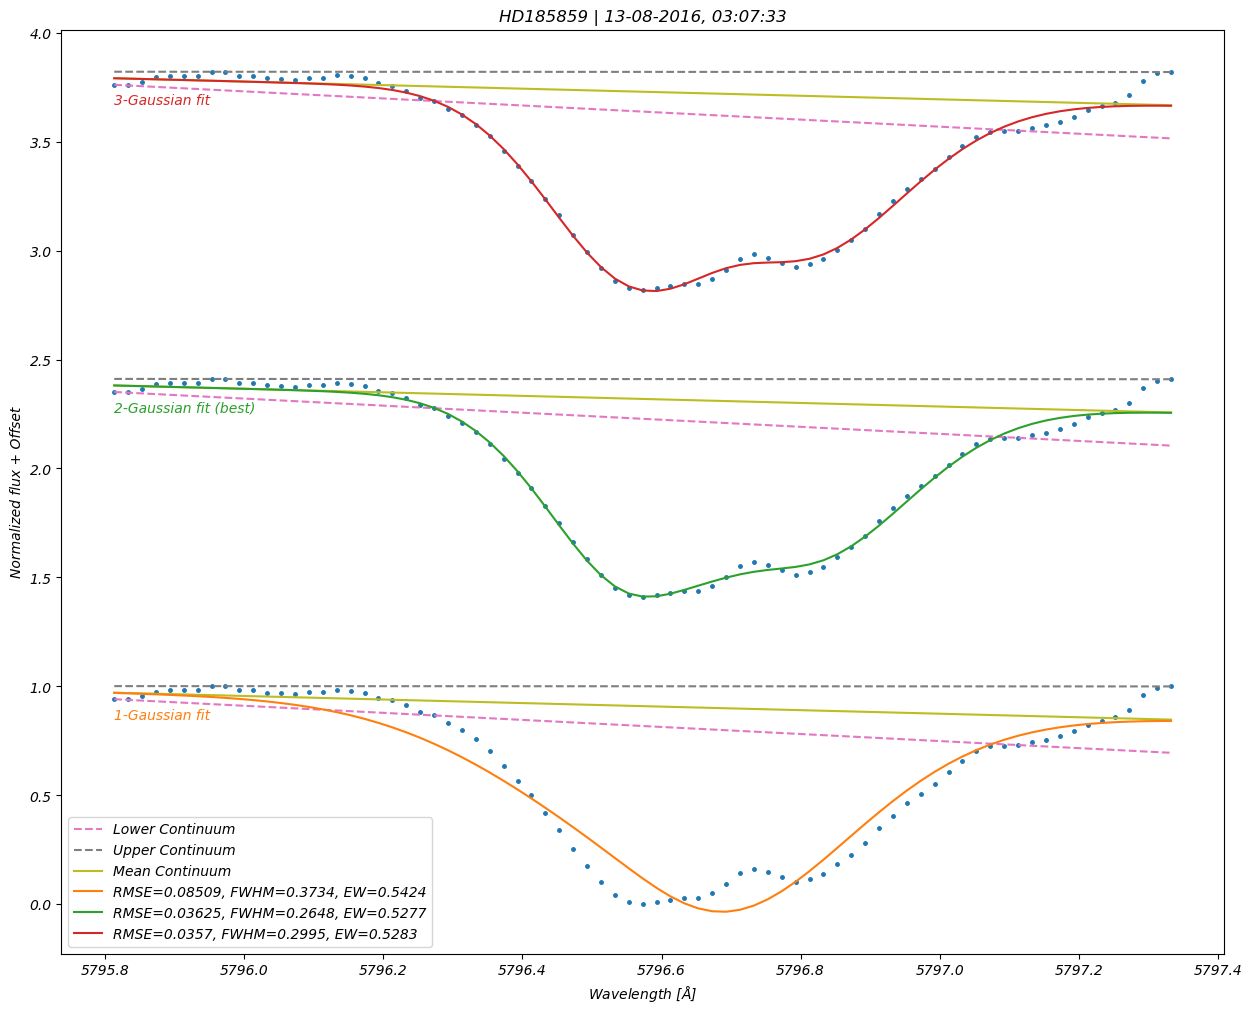

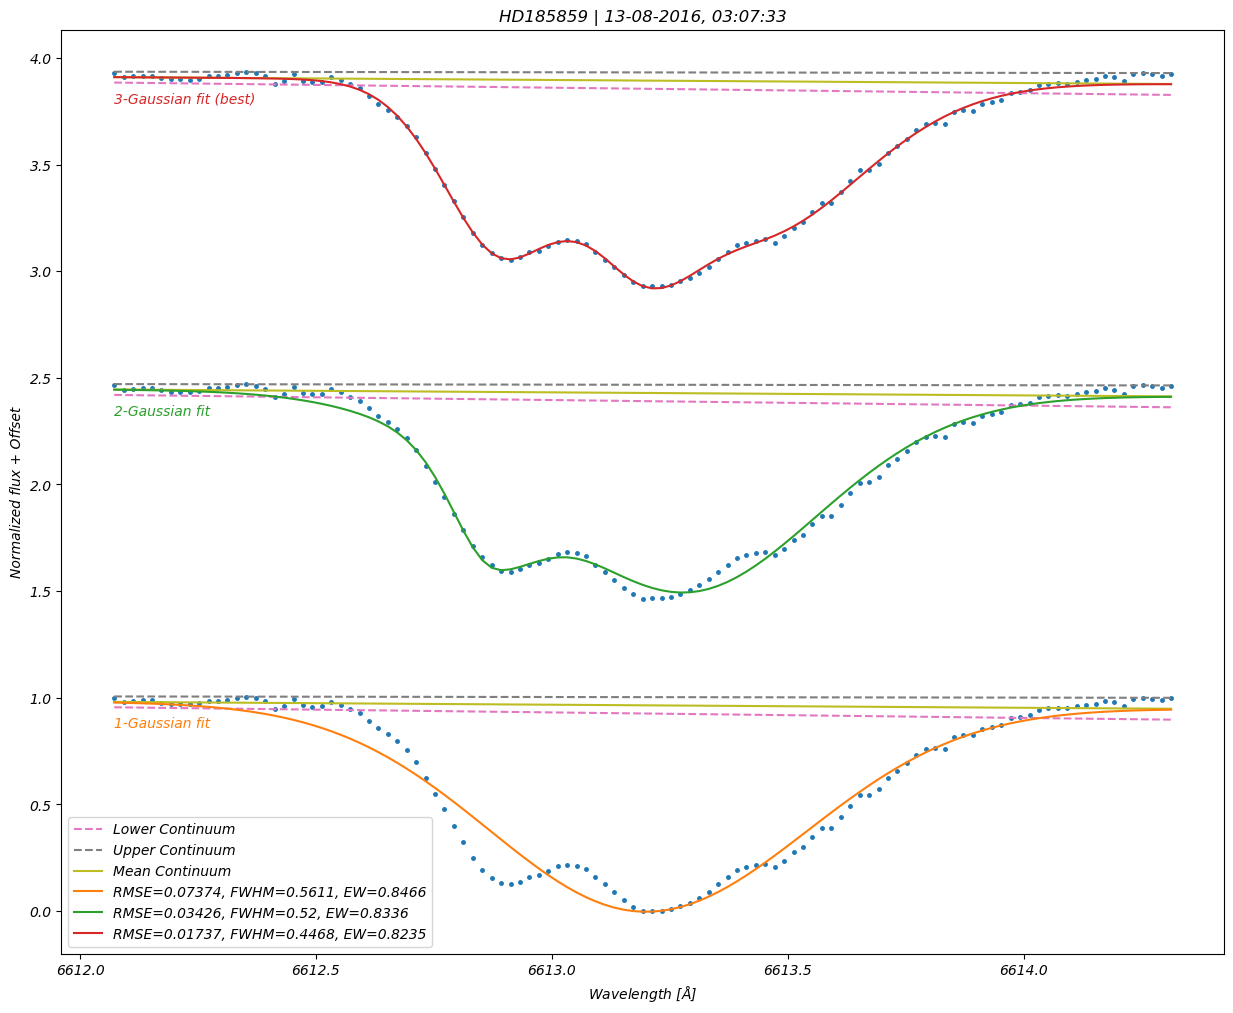

In [46]:
headers = ['Observation date', 'Start [Å]', 'End [Å]', 'Center [Å]', 'Width', 'Amplitude', 'Skew', 'RMSE', 'R2', 'FWHM [Å]', 'EW [Å]']
table_data = []

fit_gaussian_for_subspectrum(
    FitsSpectrum('data/fits/HD185859/RED_564/HD185859_w564_n8_20160813_U.fits'),
    expected_dib_centers=[5780, 5797, 6613],
    create_figure=True,
    table_data=table_data
    # save_plot='5780_gauss.pdf'
    # show_error=True
)

tabulate(table_data, ['Target', *headers], tablefmt='html')

#### All of HD170740

In [ ]:
_ = fit_gaussian_for_targets('HD170740', expected_dib_centers=dib_centers_all, export=True)

### All DIBs of all selected targets

In [ ]:
_ = fit_gaussian_for_targets(['HD147889', 'HD158926', 'HD170740', 'HD185859'], expected_dib_centers=dib_centers_all, export=True)